In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from datetime import datetime
from pathlib import Path

from typing import List

In [3]:

def read_tawiki_dump(f: Path, awk_format: bool = False) -> pd.DataFrame:
    sep = ' ' if awk_format else ","
    df = pd.read_csv(f, header=None, sep=sep)

    def parse_datetime(dt: str) -> datetime:
        d, t = dt.split(' ')
        hhmmss, mcsec = t.split('.')
        hhmmss = hhmmss.rjust(6, '0')
        return datetime(
            year=int(d[:4]), month=int(d[4:6]), day=int(d[6:]),
            hour=int(hhmmss[:2]), minute=int(hhmmss[2:4]), second=int(hhmmss[4:]),
            # microsecond=int(mcsec),
        )

    df.drop(df.columns[[7, 8]], axis=1, inplace=True)  # these are always zero after sdascii.run
    df.insert(0, 'datetime', df.iloc[:,0].astype(str) + " " + df.iloc[:,1].astype(str))
    df.drop(df.columns[[1, 2]], axis=1, inplace=True)
    df.columns = ['datetime', 'x_core_km', 'y_core_km', 'S800', 'theta_deg', 'phi_deg', 'E']
    df['datetime'] = df['datetime'].map(parse_datetime)

    return df

def read_tawiki_dumps(paths: List[Path]) -> pd.DataFrame:
    return pd.concat([read_tawiki_dump(p) for p in paths], ignore_index=True)


In [4]:
test_dumps_dir = Path("./tawiki-dumps/v2")

E_MIN = "1800"
dump_files = []
for subdir in test_dumps_dir.iterdir():
    for file in subdir.iterdir():
        if file.name.endswith(".sdascii") and E_MIN in file.name:
            dump_files.append(file)

# test_df = read_tawiki_dumps(dump_files)

In [5]:
def compare_datasets(
    base_data: pd.DataFrame,
    base_name: str,
    test_data: pd.DataFrame,
    test_name: str,
    base_col: str = None,
    test_col: str = None,
):
    print(f"{base_name}: {len(base_data)} events")
    print(f"{test_name}: {len(test_data)} events")
    
    param_names = ['x_core_km', 'y_core_km', 'S800', 'theta_deg', 'phi_deg', 'E']
    log_params = ['S800', 'E']

    param_labels = {
        'x_core_km': r'$X_{core},~\mathrm{km}$',
        'y_core_km': r'$Y_{core},~\mathrm{km}$',
        'S800': r'$log_{10}(S_{800})$',
        'theta_deg': r'$\theta, ^{\circ}$',
        'phi_deg': r'$\varphi, ^{\circ}$',
        'E': r'$log_{10}(E / 1~\mathrm{EeV})$',
    }

    fig, axes = plt.subplots(nrows=1, ncols=len(param_names), figsize=(25, 6))
    axes: List[plt.Axes]
    for (ax, param_name) in zip(axes, param_names):
        base_series = base_data[param_name]
        test_series = test_data[param_name]

        if param_name in log_params:
            base_series = np.log10(base_series)
            test_series = np.log10(test_series)

        ax.set_title(param_labels[param_name])

        min_value = min(base_series.min(), test_series.min())
        max_value = max(base_series.max(), test_series.max())
        bins = 30
        ax.hist(
            base_series, bins=bins, range=(min_value, max_value),
            density=True, label=base_name, color=base_col,
        )
        ax.hist(
            test_series, bins=bins, range=(min_value, max_value),
            density=True, label=test_name, color=test_col,
            histtype='step', linewidth=2,
        )
        ax.legend()
    
    plt.savefig(f"pics/v2/{base_name}-vs-{test_name}.png", bbox_inches="tight")
    plt.show()


In [6]:
# exp_df = read_tawiki_dump("expdata.sdascii")
# mc_df = read_tawiki_dump("pm_ivanov.awk", awk_format=True)
# compare_datasets(exp_df, "experiment", test_df, "tasdmc tool", base_col="#b1bf33")
# compare_datasets(mc_df, "standard mc", test_df, "tasdmc tool", base_col='#ef7fbe')

old c2g: 319215 events
new c2g: 343175 events


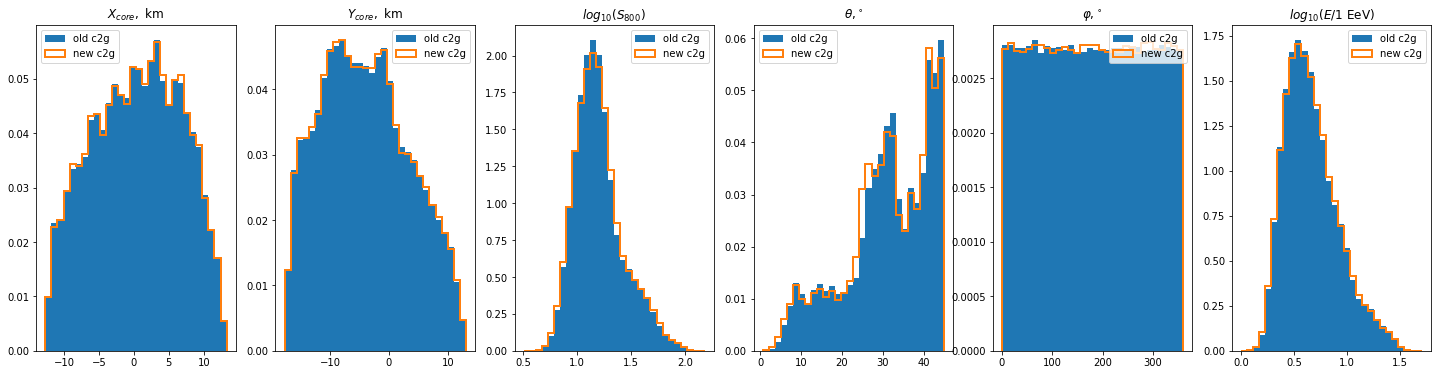

In [7]:
# the file names are mixed up!

c2g_old = read_tawiki_dump("tawiki-dumps/c2g-eval-2/tawiki_new.sdascii")
c2g_new = read_tawiki_dump("tawiki-dumps/c2g-eval-2/tawiki_old.sdascii")
compare_datasets(c2g_old, "old c2g", c2g_new, "new c2g")


old c2g: 319215 events
old c2g [2]: 316572 events


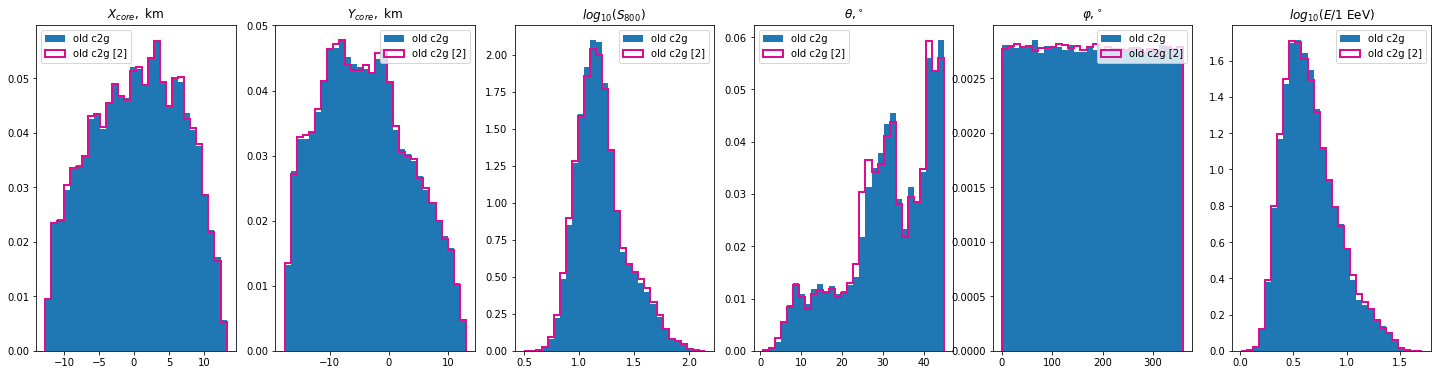

In [8]:
c2g_old_v1 = read_tawiki_dump("tawiki-dumps/fluct/tawiki_old_v1.sdascii")
c2g_old_v2 = read_tawiki_dump("tawiki-dumps/fluct/tawiki_old_v2.sdascii")
compare_datasets(c2g_old_v1, "old c2g", c2g_old_v2, "old c2g [2]", test_col="#db0d90")

In [17]:
with open("tawiki-dumps/fluct/corsika_thetas.txt") as f:
    theta_true = [float(line) for line in f]

theta_true = np.array(theta_true)

theta_true = theta_true * (180 / np.pi)

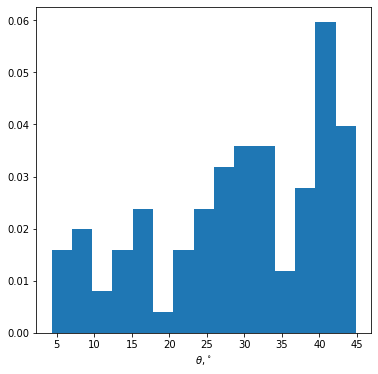

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(theta_true[theta_true < 45.0], bins=15, density=True)
ax.set_xlabel(r'$\theta, ^{\circ}$')
fig.savefig("pics/c2g-test-true-theta-dist.png")
plt.show()